# Wine Quality

In this tutorial we will be analyzing a data set on wine quality taken from the [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/index.html). The data consists of a chemical analysis of many types of wine and each is given a quality score. You can read more about the data [here](http://archive.ics.uci.edu/ml/index.html). Some math concepts in this tutorial will not be covered in detail. Please see the **Math Primer** in the [GitHub Repo](https://github.com/PythonWorkshop/intro-to-tensorflow.git) for an excellent discussion of common math concepts in machine learning.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from builtins import range
from builtins import zip

import numpy as np

import pandas as pd

## Load the data

The Pandas following command will load the data into a structure called a dataframe. This is like an Excel spreadsheet table and the data can be manipulated in similar ways to Excel data.

In [2]:
red_wine = pd.read_csv('winequality-red.csv', sep=';')

Let's take a look at the data. A good way to do this is using the **`info()`**, **`head()`**, and **`describe()`** functions in Pandas.

In [3]:
red_wine.head()  # This command displays the column headings and first five rows of data.

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
red_wine.describe().T  # This command displayes statistics about each column with numerical data.

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [5]:
red_wine.info()  # This command displays the column types and size for the data frame.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


### Discussion Question:
Looking at the dataset, what is the dimensionality? How many features are there? Can you identify which column is the label column?

We will focus on the red wines for this study.

## Scatter plot matrix
To better understand the data, we will use a scatter plot matrix. This is a plot comparing all values in the data set by plotting one value versus the other. All features are labeled both on the x-axis and the y-axis. If, for example, you want to compare **`citric acid`** and **`sulphates`** you would read off **`citric acid`** from the x-axis and then go up to **`sulphates`** on the y-axis to find the plot that compares these two features. If you compare the same feature with itself you will see a histogram showing it's distribution. It provides a good way to see how the different features are related to eachother. 

We will use the Python visualization library Seaborn to make these plots. [Seaborn](https://stanford.edu/~mwaskom/software/seaborn/index.html) is a great tool for high level statistical graphics.

In [6]:
import seaborn as sb
sb.set_context("notebook", font_scale=2.5)

from matplotlib import pyplot as plt

%matplotlib inline

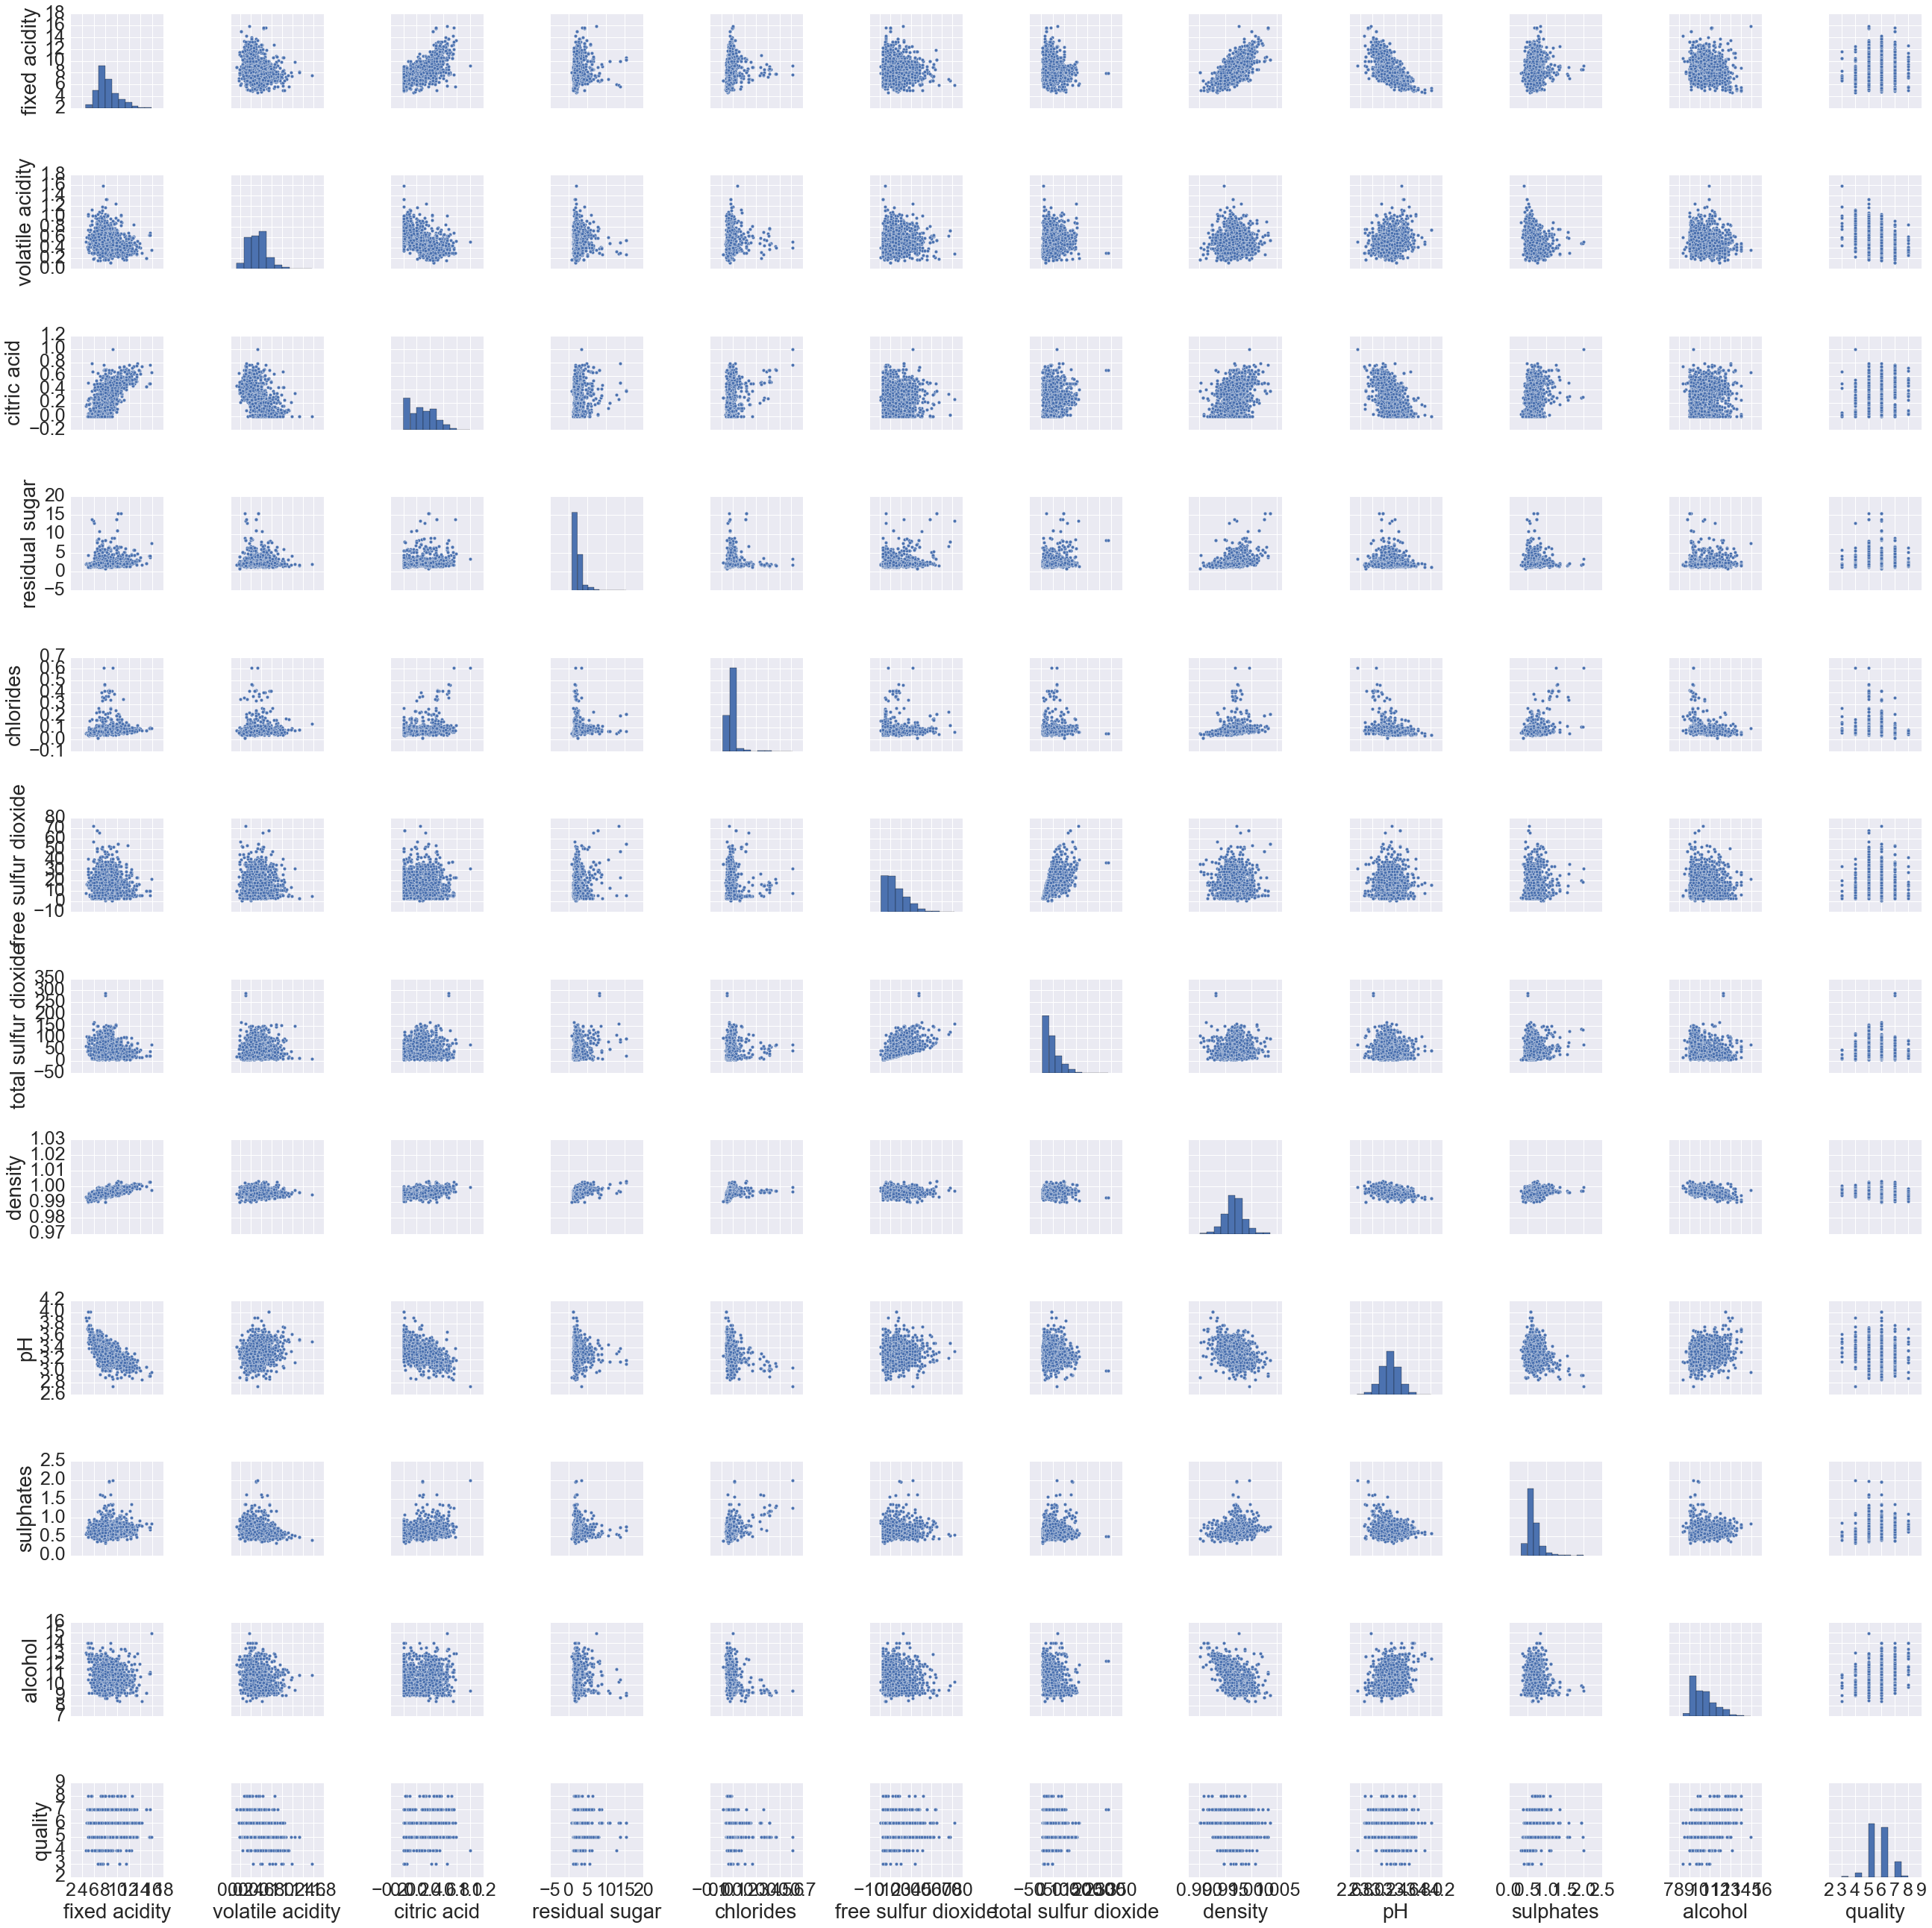

In [7]:
sb.pairplot(red_wine, size=3)

## Outliers
If you look at the plots you will notice some of the features show outliers. For example, let's look at the plots comparing **`sulphates`** and **`free sulfar dioxide`**. I circle in red points that look like there clearly deviate from the mean.

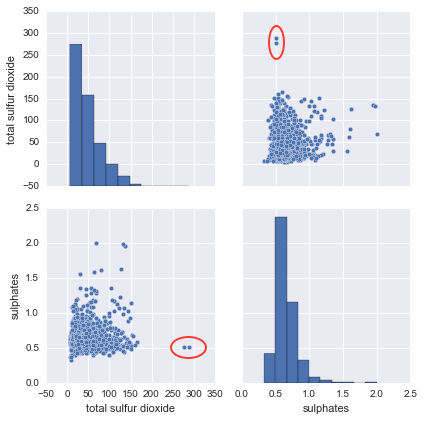

In [8]:
from IPython.display import Image
Image(filename='images/fig1.png')

In [9]:
red_wine[['total sulfur dioxide', 'sulphates']].describe().T

,count,mean,std,min,25%,50%,75%,max
total sulfur dioxide,1599.0,46.467792,32.895324,6.00,22.00,38.00,62.00,289.0
sulphates,1599.0,0.658149,0.169507,0.33,0.55,0.62,0.73,2.0


To exclude the outliers I defined the function below. It takes as input a dataframe, a threshold defined as number of standard deviations from the mean, and which columns you want to 'clean'. It then sets any value that is above the threshold to the mean of that column.

In [10]:
def outliers(df, threshold, columns):
    for col in columns: 
        mask = df[col] > float(threshold)*df[col].std()+df[col].mean()
        df.loc[mask == True,col] = np.nan
        mean_property = df.loc[:,col].mean()
        df.loc[mask == True,col] = mean_property
    return df

In [11]:
column_list = red_wine.columns.tolist() # Save the column names for the wine dataframe to a list.

Below, I set the threshold to five. Any value more than five standard deviations from the mean will be labeled as an outlier.

In [12]:
threshold = 5

In [13]:
red_wine_cleaned = red_wine.copy()
red_wine_cleaned = outliers(red_wine_cleaned, threshold, column_list[0:-1])
red_wine_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527162,0.177113,0.12000,0.3900,0.52000,0.640000,1.33000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.463948,1.076293,0.90000,1.9000,2.20000,2.600000,9.00000
chlorides,1599.0,0.082942,0.025960,0.01200,0.0700,0.07900,0.089000,0.27000
free sulfur dioxide,1599.0,15.839800,10.365444,1.00000,7.0000,14.00000,21.000000,68.00000
total sulfur dioxide,1599.0,46.170946,31.806575,6.00000,22.0000,38.00000,62.000000,165.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.652495,0.148975,0.33000,0.5500,0.62000,0.730000,1.36000


Now let's examine the data again with the outliers removed.

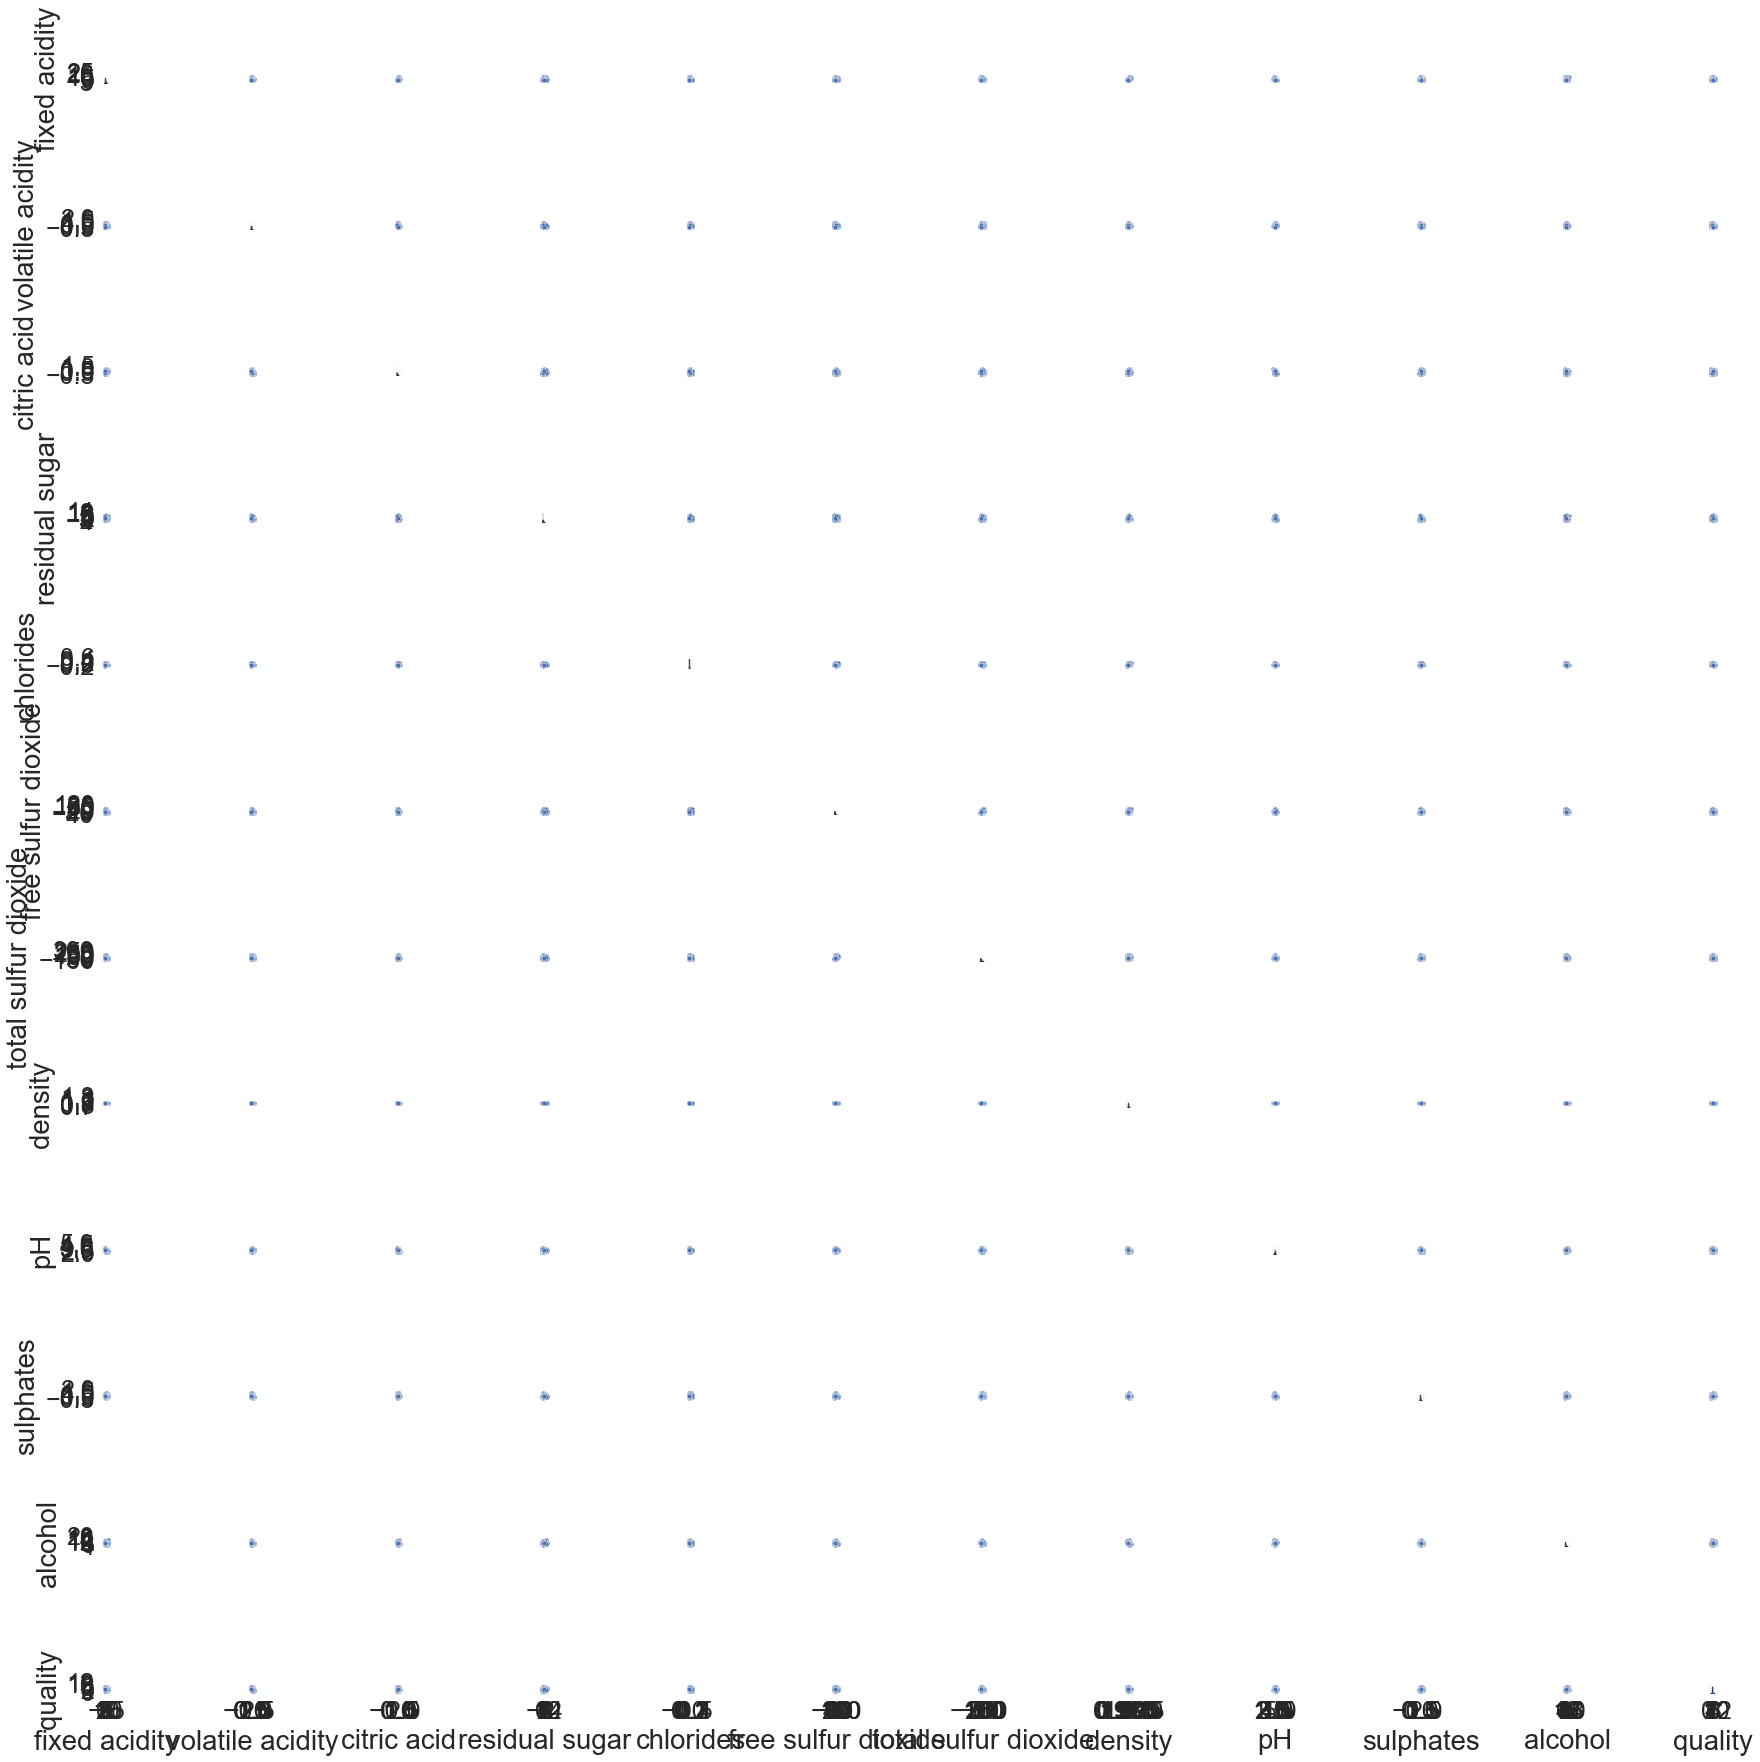

In [14]:
sb.pairplot(red_wine_cleaned, size=2)

Let's compare the two features **`total sulfur dioxide`** and **`sulphates`** again, with and with out outliers, to see the difference.

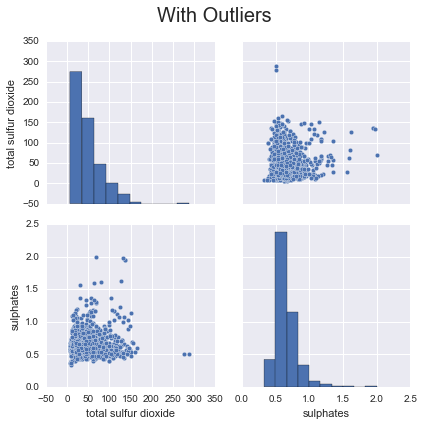

In [15]:
sb.set_context("notebook", font_scale=1)
pp = sb.pairplot(red_wine[['total sulfur dioxide', 'sulphates']], size=3)
plt.subplots_adjust(top=0.9)
pp.fig.suptitle('With Outliers', fontsize=20, verticalalignment='top')

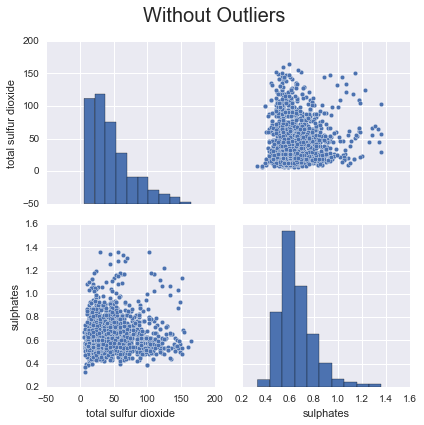

In [16]:
sb.set_context("notebook", font_scale=1)
pp = sb.pairplot(red_wine_cleaned[['total sulfur dioxide', 'sulphates']], size=3)
plt.subplots_adjust(top=0.9)
pp.fig.suptitle('Without Outliers', fontsize=20, verticalalignment='top')

### Exercise:
Change the threshold value and see how this affects the results.

### Discussion Question:
In this tutorial, we defined bad values as being outliers and removed them. Can you think of other types of bad values one might consider? How can they be removed?

## Binning the data by category

Now we will bin the data to define categories. Our model will try to infer the category given the various chemical properties meassured for the wine dataset.

In [17]:
print("The range is wine quality is {0}".format(np.sort(red_wine_cleaned['quality'].unique())))

The range is wine quality is [3 4 5 6 7 8]


First, we will bin the data into three bins based on their quality, 'Bad', 'Average', and 'Good'.

In [18]:
bins = [3, 5, 6, 8]
red_wine_cleaned['category'] = pd.cut(red_wine_cleaned.quality, bins, labels=['Bad', 'Average', 'Good'])

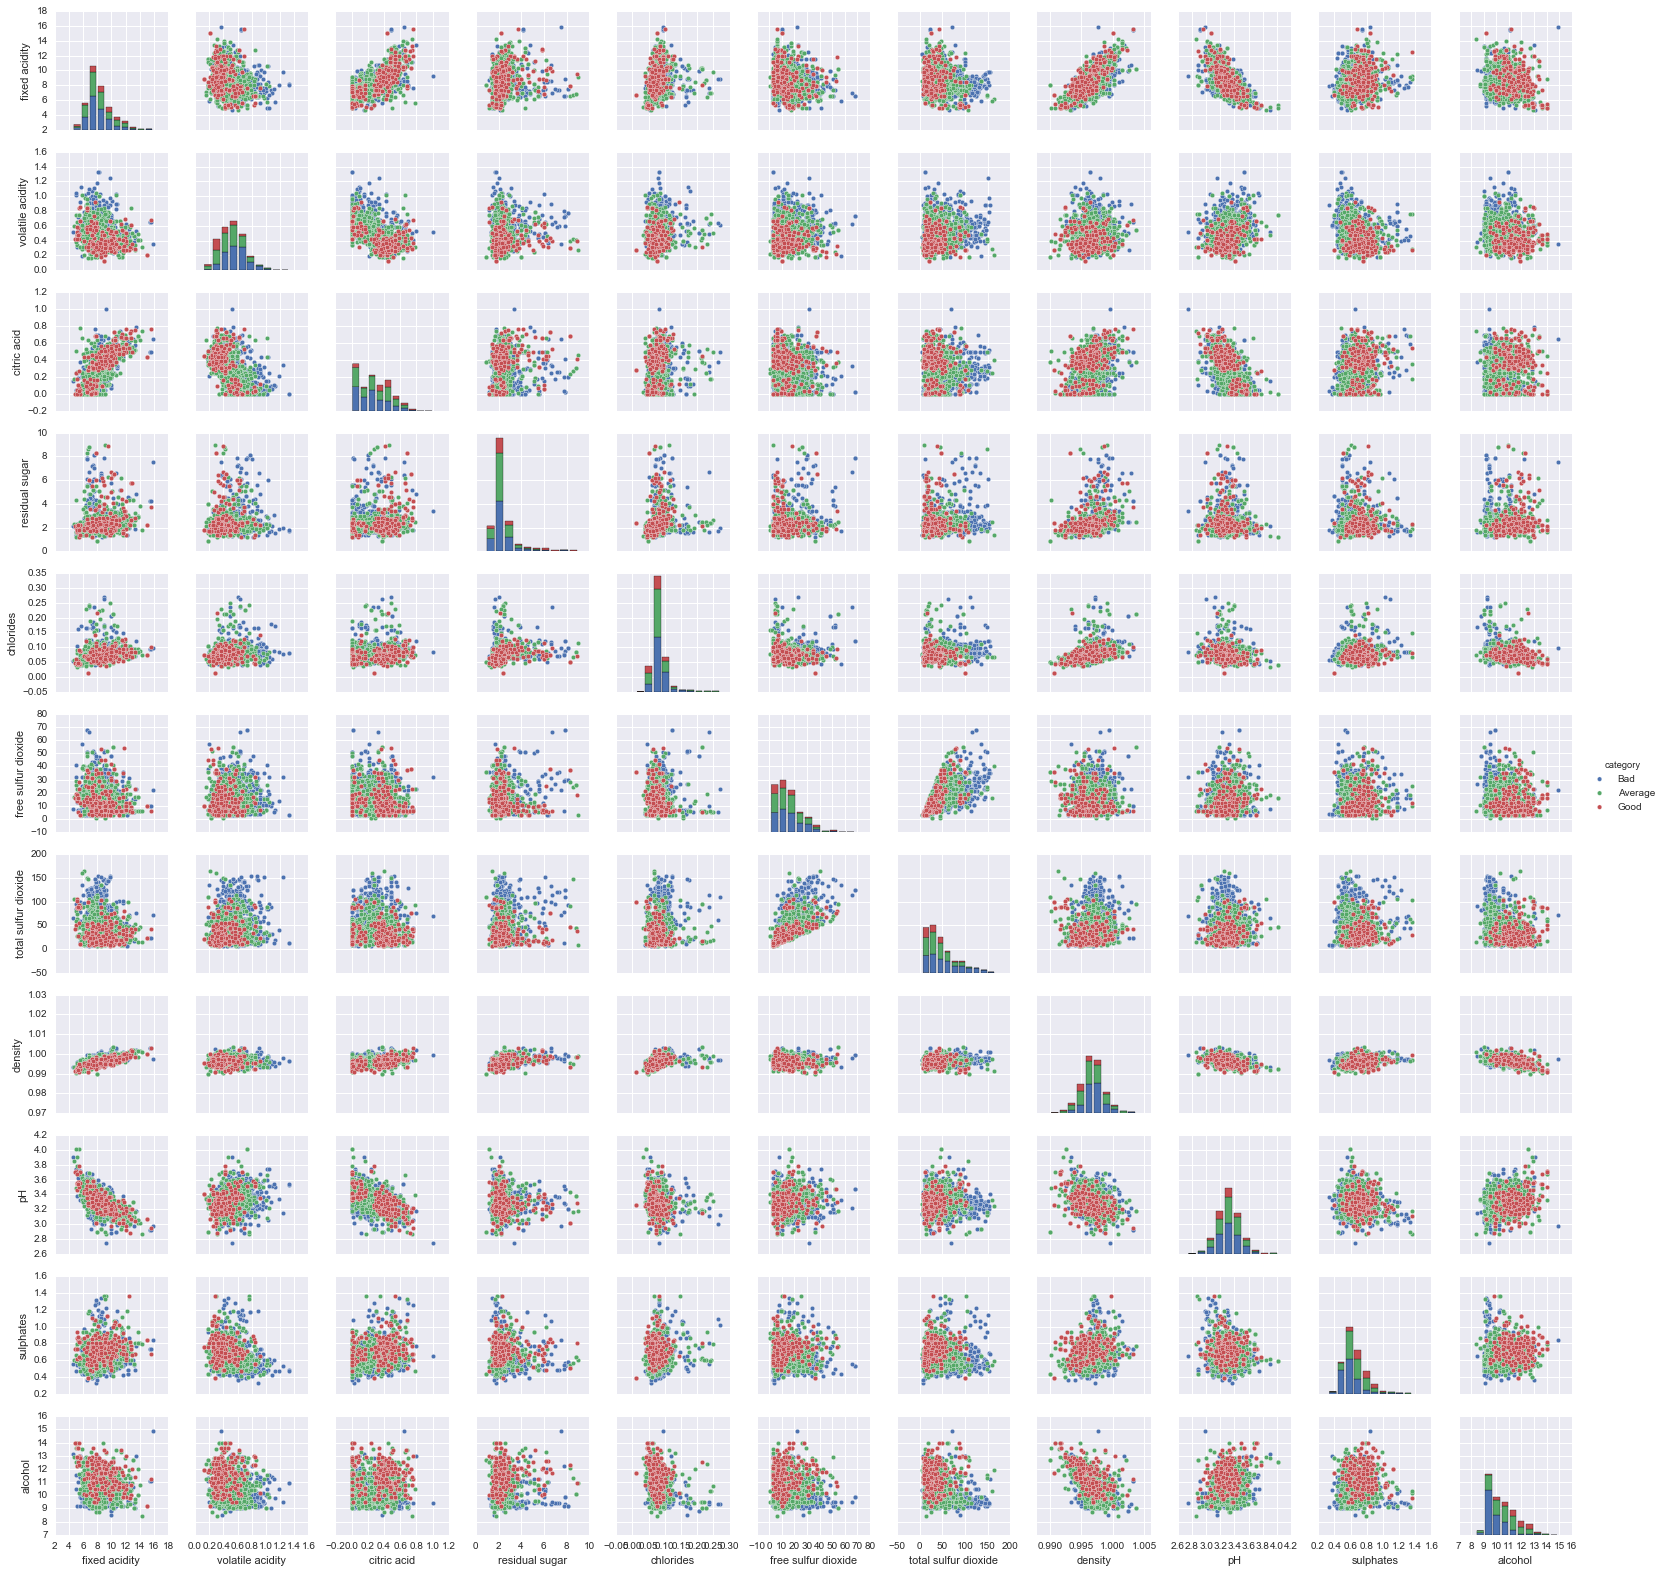

In [19]:
sb.pairplot(red_wine_cleaned.drop(['quality'],1), hue='category', size=2)

We can examine some metrics by category using the Pandas routines **`groupby()`** and **`agg()`**. The function **`groupby()`** allows you to group the data by a column. In this case we went to group by `category`. We can then use the **`agg()`** function to get the mean and standard deviation of all the value in each group. If you want to learn more, please read the [Pandas documentation](http://pandas.pydata.org/pandas-docs/stable/indexing.html).

In [20]:
red_wine_cleaned.drop('quality', 1).groupby('category').agg(['mean', 'std']).T

category                         Bad    Average       Good
fixed acidity        mean   8.139237   8.347179   8.847005
                     std    1.570668   1.797849   1.999977
volatile acidity     mean   0.585484   0.497484   0.405530
                     std    0.171900   0.160962   0.144963
citric acid          mean   0.238665   0.273824   0.376498
                     std    0.182344   0.195108   0.194438
residual sugar       mean   2.477937   2.361909   2.708756
                     std    1.104039   0.902309   1.363026
chlorides            mean   0.085496   0.082206   0.074645
                     std    0.024194   0.027374   0.021008
free sulfur dioxide  mean  16.643052  15.623573  13.981567
                     std   10.891157   9.687108  10.234615
total sulfur dioxide mean  55.050409  40.869906  32.702036
                     std   36.756984  25.038250  22.017111
density              mean   0.997063   0.996615   0.996030
                     std    0.001593   0.002000   0.002201
pH                   mean   3.310477   3.318072   3.288802
                     std    0.154189   0.153995   0.154478
sulphates            mean   0.611720   0.669761   0.743456
                     std    0.149053   0.136632   0.134038
alcohol              mean   9.926090  10.629519  11.518049
                     std    0.757750   1.049639   0.998153

Notice that there is quite a bit of overlap between the average values and the bad values. To improve the model fitting, we will throw out the average values and only perform a classification between the 'Good' wine and the 'Bad' wine.

In [21]:
red_wine_newcats = red_wine_cleaned[red_wine_cleaned['category'].isin(['Bad', 'Good'])].copy()

In [22]:
np.sort(red_wine_newcats['quality'].unique())

array([4, 5, 7, 8])

In [23]:
bins = [3, 5, 8]
red_wine_newcats['category'] = pd.cut(red_wine_newcats.quality, bins, labels=['Bad', 'Good'])

In [24]:
red_wine.shape, red_wine_newcats.shape

((1599, 12), (951, 13))

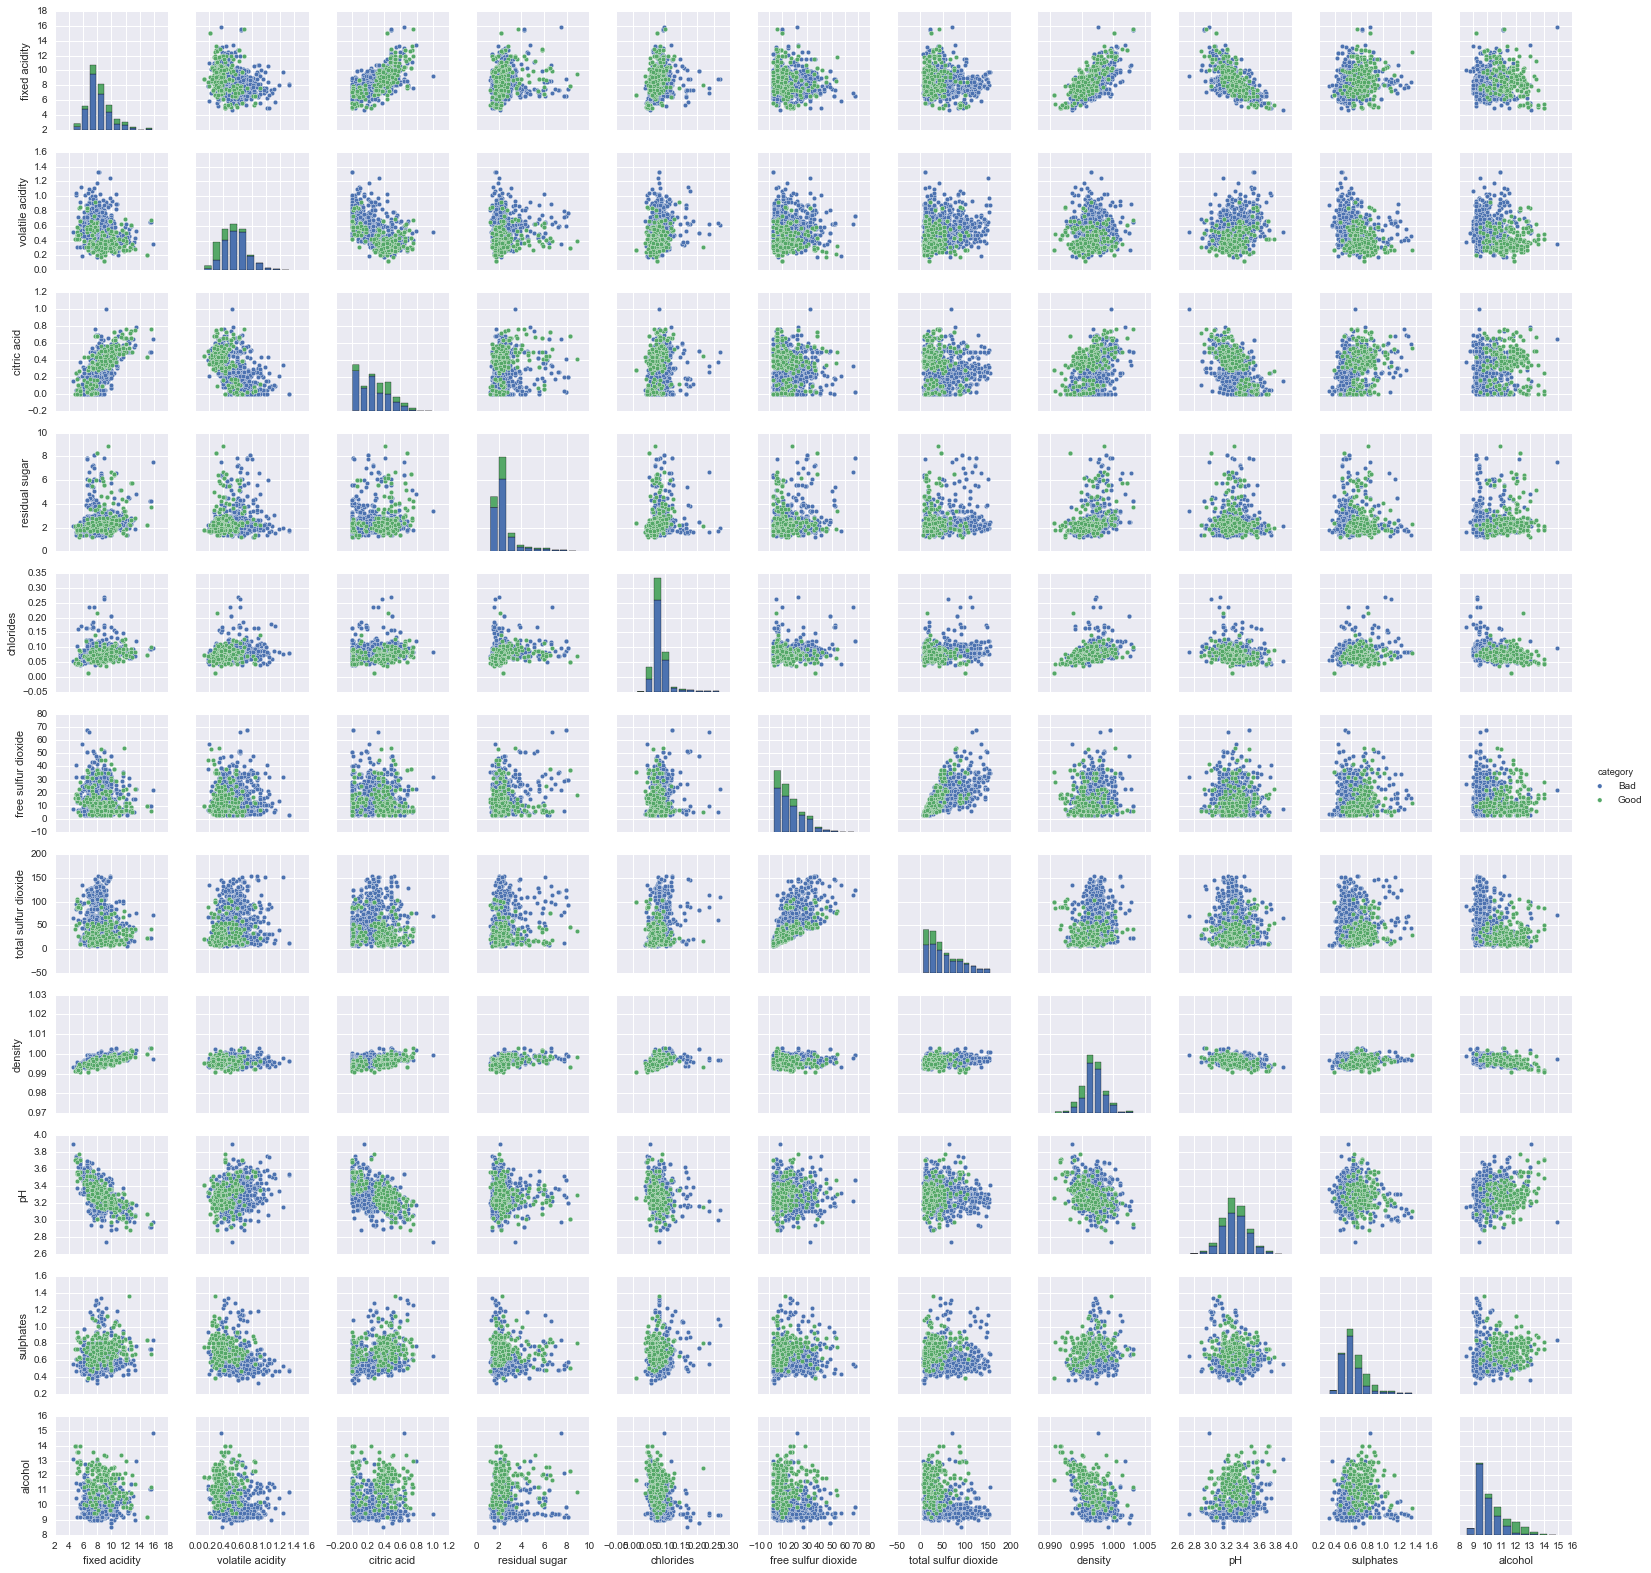

In [25]:
sb.pairplot(red_wine_newcats.drop(['quality'],1), hue='category', size=2)

In [26]:
red_wine_newcats.drop('quality', 1).groupby('category').agg(['mean', 'std']).T

category                         Bad       Good
fixed acidity        mean   8.139237   8.847005
                     std    1.570668   1.999977
volatile acidity     mean   0.585484   0.405530
                     std    0.171900   0.144963
citric acid          mean   0.238665   0.376498
                     std    0.182344   0.194438
residual sugar       mean   2.477937   2.708756
                     std    1.104039   1.363026
chlorides            mean   0.085496   0.074645
                     std    0.024194   0.021008
free sulfur dioxide  mean  16.643052  13.981567
                     std   10.891157  10.234615
total sulfur dioxide mean  55.050409  32.702036
                     std   36.756984  22.017111
density              mean   0.997063   0.996030
                     std    0.001593   0.002201
pH                   mean   3.310477   3.288802
                     std    0.154189   0.154478
sulphates            mean   0.611720   0.743456
                     std    0.149053   0.134038
alcohol              mean   9.926090  11.518049
                     std    0.757750   0.998153

### Discussion Question:
Examine the 'cleaned' pairplot above. Can you identify any features that appear related to eachother? Hint: Think back to highschool chemistry class. Features that have a linear dependancy are called collinear and can be problematic if they are included in modeling. See the Math Primer for a discussion of collinearity.

## Heat Map
Another way to visualize the data is using a heat map in Seaborn. Like **`pairplot()`**, all the features in the dataframe a plotted against each other. But, in this case each plot is a color block. The color represents the amount of coorelation between the two variables plotted. The more positive the correlation, the reader the square. The more negative the correlation, the bluer the square. If there is no correlation, the square appears white. As you can imagine, this is a good way to quickly see correlations. But, a lot of the detail seen in the scatter plots is lost.

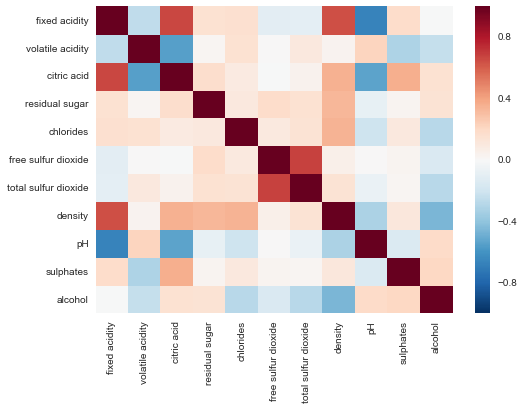

In [27]:
sb.heatmap(red_wine_newcats.drop(['quality'],1).corr())

## Using skflow

Before using TensorFlow, we will use skflow to make the model. Skflow is a Python library the wraps many of the TensorFlow commands in routines the are more like scikit-learn. Therefore, if you are more familiar with scikit-learn, using Skflow can be a good way to get a gental introduction to TensorFlow.

In [28]:
import sklearn
from sklearn import metrics, preprocessing
from sklearn.cross_validation import train_test_split

import tensorflow.contrib.learn as skflow

It looks like total sulfar dioxide is a good indicator of wine quality. The two categories appear quite distinct in this feature. Let's try using this feature to classify whether the wine is a 'Good' wine or a 'Bad' wine.

### Separate data into labels and features
Here we separate the data into 'labels' (y values) and 'feature' (X values) and divide them into training and test sets using train_test_split() from scikit-learn.

In [29]:
y_red_wine = red_wine_newcats[['category']].get_values()

In [30]:
X_red_wine = red_wine_newcats['total sulfur dioxide'].get_values()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_red_wine, y_red_wine, test_size=0.2, random_state=42)

The y values are string categories ('Good' and 'Bad') and so need to be converted to integers so that skflow will understand the categories. This is done using fit_transform() from the CategoricalProcessor class in skflow.

In [32]:
cat_processor = skflow.preprocessing.CategoricalProcessor()
y_train_cat = np.array(list(cat_processor.fit_transform(y_train)))
y_test_cat = np.array(list(cat_processor.transform(y_test)))

In [33]:
n_classes = len(cat_processor.vocabularies_[0])

Let's see how many different classes there are:

In [34]:
print("There are {0} different classes.".format(n_classes))

There are 3 different classes.


You will notice that there are 3 classes, but as you will remember, there are only two categories. That's because the **`CategoricalProcessor()`** also includes an uknown token.

In [35]:
# Define the model
def categorical_model(X, y):
    return skflow.models.logistic_regression(X, y)

In [36]:
# Train the model
classifier = skflow.TensorFlowEstimator(model_fn=categorical_model,
    n_classes=3, learning_rate=0.01)

In [37]:
classifier.fit(X_train, y_train_cat)

/Users/dave/anaconda/lib/python2.7/site-packages/tensorflow/contrib/learn/python/learn/io/data_feeder.py:281: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  out.itemset((i, self.y[sample]), 1.0)


Step #100, epoch #4, avg. train loss: 12.05960
Step #200, epoch #8, avg. train loss: 2.73690


TensorFlowEstimator(batch_size=32, class_weight=None, clip_gradients=5.0,
          config=None, continue_training=False, learning_rate=0.01,
          model_fn=<function categorical_model at 0x1624c2230>,
          n_classes=3, optimizer='Adagrad', steps=200, verbose=1)

In [38]:
print("Accuracy: {0}".format(metrics.accuracy_score(classifier.predict(X_test), y_test_cat)))

Accuracy: 0.764397905759


Not bad for a start! Now the model needs to be revised.

### Categorical Model with Two Features

Now let's try two features, '`total sulfur dioxide`' and '`citric acid`', to see if this improves the model.

In [39]:
X_red_wine = red_wine_newcats[['total sulfur dioxide','citric acid']].get_values()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_red_wine, y_red_wine, test_size=0.2, 
                                                    random_state=42)

In [41]:
cat_processor = skflow.preprocessing.CategoricalProcessor()
y_train_cat = np.array(list(cat_processor.fit_transform(y_train)))
y_test_cat = np.array(list(cat_processor.transform(y_test)))

In [42]:
n_classes = len(cat_processor.vocabularies_[0])

In [43]:
print("There are {0} different classes.".format(n_classes))

There are 3 different classes.


In [44]:
# Define the model
def categorical_model(X, y):
    return skflow.models.logistic_regression(X, y)

In [45]:
# Train the model
classifier = skflow.TensorFlowEstimator(model_fn=categorical_model,
    n_classes=3, learning_rate=0.01)

In [46]:
classifier.fit(X_train, y_train_cat)

Step #100, epoch #4, avg. train loss: 5.78503
Step #200, epoch #8, avg. train loss: 0.47578


TensorFlowEstimator(batch_size=32, class_weight=None, clip_gradients=5.0,
          config=None, continue_training=False, learning_rate=0.01,
          model_fn=<function categorical_model at 0x16271daa0>,
          n_classes=3, optimizer='Adagrad', steps=200, verbose=1)

In [47]:
print("Accuracy: {0}".format(metrics.accuracy_score(classifier.predict(X_test), y_test_cat)))

Accuracy: 0.764397905759


This fit is about the same. Not much improvement.

### Catagorical Model Using Ten Features
We will now add additional features. Let's include all features except fixed acidity, which shows some colinearity with pH and density.

In [48]:
red_wine_newcats.iloc[:,1:-2].head()

,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
5,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4


In [49]:
X_red_wine = red_wine_newcats.iloc[:,1:-2].get_values()

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_red_wine, y_red_wine, test_size=0.2, 
                                                    random_state=42)

In [51]:
cat_processor = skflow.preprocessing.CategoricalProcessor()
y_train_cat = np.array(list(cat_processor.fit_transform(y_train)))
y_test_cat = np.array(list(cat_processor.transform(y_test)))

In [52]:
n_classes = len(cat_processor.vocabularies_[0])

In [53]:
print("There are {0} different classes.".format(n_classes))

There are 3 different classes.


In [54]:
# Define the model
def categorical_model(X, y):
    return skflow.models.logistic_regression(X, y)

In [55]:
# Train the model
classifier = skflow.TensorFlowEstimator(model_fn=categorical_model,
    n_classes=3, learning_rate=0.07)

In [56]:
classifier.fit(X_train, y_train_cat)

Step #100, epoch #4, avg. train loss: 0.78515
Step #200, epoch #8, avg. train loss: 0.42502


TensorFlowEstimator(batch_size=32, class_weight=None, clip_gradients=5.0,
          config=None, continue_training=False, learning_rate=0.07,
          model_fn=<function categorical_model at 0x16271db90>,
          n_classes=3, optimizer='Adagrad', steps=200, verbose=1)

In [57]:
print("Accuracy: {0}".format(metrics.accuracy_score(classifier.predict(X_test), y_test_cat)))

Accuracy: 0.832460732984


**A dramatic improved accuracy!**

## Tensor Flow

Now we get serious and will use TensorFlow to model the wine quality data set.

In [58]:
import tensorflow as tf

Convert y-labels from strings to integers. Bad = 1, Good = 0.

In [59]:
y_red_wine_raveled = y_red_wine.ravel()
y_red_wine_integers = [y.replace('Bad', '1') for y in y_red_wine_raveled]
y_red_wine_integers = [y.replace('Good', '0') for y in y_red_wine_integers]
y_red_wine_integers = [np.int(y) for y in y_red_wine_integers]

Convert y-labels to one-hot vectors.

In [60]:
def dense_to_one_hot(labels_dense, num_classes=2):
  # Convert class labels from scalars to one-hot vectors
  num_labels = len(labels_dense)
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense] = 1
  return labels_one_hot

In [61]:
y_one_hot = dense_to_one_hot(y_red_wine_integers, num_classes=2)

Divide the data into training and test sets

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_red_wine, y_one_hot, test_size=0.2, random_state=42)

Define modeling parameters

In [63]:
learning_rate = 0.001
batch_size = 126

In [64]:
X = tf.placeholder("float", [None,10])
Y = tf.placeholder("float", [None,2])

Set model weights and biases.

In [65]:
W = tf.Variable(tf.zeros([10, 2]))
b = tf.Variable(tf.zeros([2]))

Construct the model. We will use softmax regression since this is good for catagorial data.

In [66]:
model = tf.nn.softmax(tf.matmul(X, W) + b)

Minimize the error using cross entropy.

In [67]:
cost = -tf.reduce_mean(Y*tf.log(model))

Define the optimizer. We will use gradient descent.

In [68]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

Define a TensorFlow session and setup a directory to store the results for the tensorboard graph visualization utility.

In [69]:
sess = tf.Session()

Initialize all variables and start a TensorFlow session.

In [70]:
init = tf.initialize_all_variables()
sess.run(init)

In [71]:
for i in range(100):
    average_cost = 0
    number_of_batches = int(len(X_train) / batch_size)
    for start, end in zip(range(0, len(X_train), batch_size), range(batch_size, len(X_train), batch_size)):
        sess.run(optimizer, feed_dict={X: X_train[start:end], Y: y_train[start:end]})
        # Compute average loss
        average_cost += sess.run(cost, feed_dict={X: X_train[start:end], Y: y_train[start:end]}) / number_of_batches
    print("Epoch:", '%04d' % (i+1), "cost=", "{:.9f}".format(average_cost))
    
print('Finished optimization!')

Epoch: 0001 cost= 0.249063037
Epoch: 0002 cost= 0.245696974
Epoch: 0003 cost= 0.244979247
Epoch: 0004 cost= 0.244354119
Epoch: 0005 cost= 0.243782466
Epoch: 0006 cost= 0.243257249
Epoch: 0007 cost= 0.242773935
Epoch: 0008 cost= 0.242328577
Epoch: 0009 cost= 0.241917660
Epoch: 0010 cost= 0.241538028
Epoch: 0011 cost= 0.241186880
Epoch: 0012 cost= 0.240861637
Epoch: 0013 cost= 0.240560027
Epoch: 0014 cost= 0.240280017
Epoch: 0015 cost= 0.240019699
Epoch: 0016 cost= 0.239777451
Epoch: 0017 cost= 0.239551696
Epoch: 0018 cost= 0.239341083
Epoch: 0019 cost= 0.239144355
Epoch: 0020 cost= 0.238960398
Epoch: 0021 cost= 0.238788178
Epoch: 0022 cost= 0.238626746
Epoch: 0023 cost= 0.238475236
Epoch: 0024 cost= 0.238332875
Epoch: 0025 cost= 0.238198983
Epoch: 0026 cost= 0.238072860
Epoch: 0027 cost= 0.237953939
Epoch: 0028 cost= 0.237841668
Epoch: 0029 cost= 0.237735542
Epoch: 0030 cost= 0.237635108
Epoch: 0031 cost= 0.237539950
Epoch: 0032 cost= 0.237449663
Epoch: 0033 cost= 0.237363897
Epoch: 003

Test the model:

In [72]:
correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(y_test, 1))

Calculate the accuracy:

In [73]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
print("Accuracy: {0}".format(sess.run(accuracy, feed_dict={X: X_test, Y: y_test})))

Accuracy: 0.76963353157


### Exercise:
Change the learning rate and batch size and see how this affects the results.

## TensorFlow with Tensorboard
Now, let's rerun TensorFlow, but use Tensorboard. This will give us a graphical representation of how the model is created and fit.

Define modeling parameters

In [74]:
learning_rate = 0.001
batch_size = 126

In [75]:
X = tf.placeholder("float", [None, 10], name='X-input')
Y = tf.placeholder("float", [None, 2], name='y-input')

Set model weights and biases.

In [76]:
W = tf.Variable(tf.zeros([10, 2]), name='Weights')
b = tf.Variable(tf.zeros([2]), name='Biases')

Use a name scope to organize nodes in the graph visualizer. Scope is a TensorFlow library that allows the user to share variables.

In [77]:
with tf.name_scope("Wx_b") as scope:
  model = tf.nn.softmax(tf.matmul(X, W) + b)

Add summary ops to collect data

In [78]:
w_hist = tf.histogram_summary("Weights", W)
b_hist = tf.histogram_summary("Biases", b)
y_hist = tf.histogram_summary("model", model)

Define the loss and optimizer functions.

In [79]:
with tf.name_scope("cross_entropy") as scope:
  cross_entropy = -tf.reduce_mean(Y*tf.log(model))
  ce_summ = tf.scalar_summary("cross entropy", cross_entropy)    
with tf.name_scope("train") as scope:
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

In [80]:
with tf.name_scope("test") as scope:
  correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_summary = tf.scalar_summary("accuracy", accuracy)

Define a TensorFlow session and setup a directory to store the results for the tensorboard graph visualization utility.

In [81]:
sess = tf.Session()
merged = tf.merge_all_summaries()
writer = tf.train.SummaryWriter("tmp/wine_quality_logs", sess.graph_def)

Initialize all variables and start a TensorFlow session.

In [82]:
init = tf.initialize_all_variables()
sess.run(init)

In [83]:
for i in range(100):
    number_of_batches = int(len(X_train) / batch_size)
    if i % 10 == 0:
        feed = {X: X_test, Y: y_test}
        result = sess.run([merged, accuracy], feed_dict=feed)
        summary_str = result[0]
        acc = result[1]
        writer.add_summary(summary_str, i)
        print("Accuracy at step %s: %s" % (i, acc))
    else:
        for start, end in zip(range(0, len(X_train), batch_size), range(batch_size, len(X_train), batch_size)):
            feed = {X: X_train[start:end], Y: y_train[start:end]}
            sess.run(optimizer, feed_dict=feed)

Accuracy at step 0: 0.235602
Accuracy at step 10: 0.764398
Accuracy at step 20: 0.764398
Accuracy at step 30: 0.764398
Accuracy at step 40: 0.764398
Accuracy at step 50: 0.764398
Accuracy at step 60: 0.764398
Accuracy at step 70: 0.764398
Accuracy at step 80: 0.764398
Accuracy at step 90: 0.764398


In [84]:
print("Accuracy: {0}".format(sess.run(accuracy, feed_dict={X: X_test, Y: y_test})))

Accuracy: 0.764397919178


Navigate to the directory with this Jupyter notebook. Then launch tensorboard with the following command:

In [85]:
# !python ~/anaconda/bin/tensorboard --logdir=tmp/wine_quality_logs



*Reference: Lichman, M. (2013). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.*